In [1]:
#install required packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.4 MB/s 
     |████████████████████████████████| 3.5 MB 5.4 MB/s 


In [2]:
# helper function for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize = (10, 10))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s = 70, c = color, cmap = 'Set2')
  plt.show()

In [11]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

def data(name):
  dataset = Planetoid(root = "data/Planetoid", name = f"{name}", transform = NormalizeFeatures())
  return dataset
dataset = data("Citeseer") # chnage dataset type
print(dataset) 

print("---"*36)
print(f'length of the dataset: {len(dataset)}')
print(f'features in the dataset: {dataset.num_features}')
print(f'Number of classes in the dataset: {dataset.num_classes}')
print("---"*36)
data = dataset[0]
print('print dataset properties')
print(data)

print(f'Number of nodes in the dataset: {data.num_nodes}')
print(f'Number of edges in the dataset: {data.num_edges}')
print(f'Average Node degree: {data.num_edges/data.num_nodes:0.2f}')
print(f'number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {data.train_mask.sum()/data.num_nodes:0.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Citeseer()
------------------------------------------------------------------------------------------------------------
length of the dataset: 1
features in the dataset: 3703
Number of classes in the dataset: 6
------------------------------------------------------------------------------------------------------------
print dataset properties
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes in the dataset: 3327
Number of edges in the dataset: 9104
Average Node degree: 2.74
number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


Processing...
Done!


In [12]:
from torch_geometric.nn import GATConv
import torch
import torch.nn.functional as F

class GAT(torch.nn.Module):
  def __init__(self, hidden_channels, heads):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GATConv(dataset.num_features, hidden_channels, heads)
    self.conv2 = GATConv(hidden_channels*heads, dataset.num_classes)

  
  def forward(self, x, edge_index):
    x = F.dropout(x, p = 0.6, training = self.training)
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, p = 0.6, training= self.training)
    x = self.conv2(x, edge_index)
    return x

model = GAT(hidden_channels = 8, heads = 8)
print(model)

GAT(
  (conv1): GATConv(3703, 8, heads=8)
  (conv2): GATConv(64, 6, heads=1)
)


In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay= 5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss


def test(mask):
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  num_corrects = pred[mask] == data.y[mask]
  test_acc = int(num_corrects.sum())/int(mask.sum())
  return test_acc


for epoch in range(1, 201):
  loss = train()
  val_acc = test(data.test_mask)
  test_acc = test(data.val_mask)
  if epoch % 10 ==0:
    print(f'Epoch: {epoch:03d}, loss: {loss:.4f}, val: {val_acc:.4f}, test: {test_acc:.4f}')

Epoch: 010, loss: 1.6790, val: 0.6700, test: 0.6620
Epoch: 020, loss: 1.4529, val: 0.6770, test: 0.6840
Epoch: 030, loss: 1.1856, val: 0.6970, test: 0.6980
Epoch: 040, loss: 0.9336, val: 0.7190, test: 0.7220
Epoch: 050, loss: 0.7637, val: 0.7150, test: 0.7040
Epoch: 060, loss: 0.5731, val: 0.7100, test: 0.7040
Epoch: 070, loss: 0.5452, val: 0.7190, test: 0.7000
Epoch: 080, loss: 0.4810, val: 0.7100, test: 0.6920
Epoch: 090, loss: 0.4044, val: 0.7120, test: 0.7140
Epoch: 100, loss: 0.4141, val: 0.7020, test: 0.7020
Epoch: 110, loss: 0.3864, val: 0.7170, test: 0.7000
Epoch: 120, loss: 0.3935, val: 0.7140, test: 0.6940
Epoch: 130, loss: 0.3433, val: 0.7020, test: 0.7000
Epoch: 140, loss: 0.3352, val: 0.7040, test: 0.7120
Epoch: 150, loss: 0.3696, val: 0.6900, test: 0.6800
Epoch: 160, loss: 0.3501, val: 0.6930, test: 0.6880
Epoch: 170, loss: 0.3121, val: 0.6860, test: 0.6860
Epoch: 180, loss: 0.3115, val: 0.6870, test: 0.6780
Epoch: 190, loss: 0.2985, val: 0.6900, test: 0.6760
Epoch: 200, 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


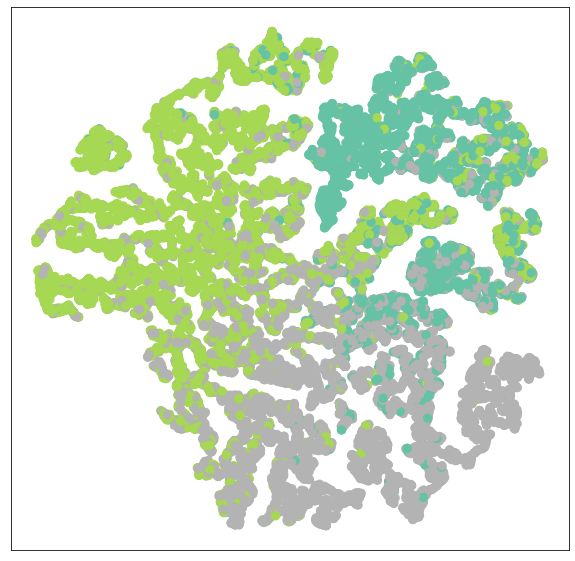

In [10]:
model.eval()  # inference using GAT

out = model(data.x, data.edge_index)
visualize(out, color=data.y)